In [104]:
# ----- Imports ----- #
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

words = open("names.txt").read().splitlines()

In [105]:
# ----- Vocab Mapping ----- #
chars = sorted(list(set("".join(words))))
string_to_int = {c: i+1 for i, c in enumerate(chars)}
string_to_int["."] = 0
integer_to_string = {i: c for c, i in string_to_int.items()}

In [106]:
# ----- Build Dataset Function ----- #

block_size = 3

def build_dataset(words):
    contexts, targets = [], []
    for word in words:
        context = [0] * block_size
        for char in word + ".":
            int_char = string_to_int[char]
            contexts.append(context)
            targets.append(int_char)
            
            context = context[1:] + [int_char]
    
    contexts = torch.tensor(contexts)
    targets = torch.tensor(targets)
    
    return contexts, targets

# ----- Shuffle and Split Dataset (train: 80%, dev: 10%, test: 10%) ----- #

random.seed(42) # for reproducibility
random.shuffle(words)

train_split_index = int(len(words) * 0.8)
dev_split_index = int(len(words) * 0.9)

X_train, y_train = build_dataset(words[:train_split_index]) # 80% of data
X_dev, y_dev = build_dataset(words[train_split_index:dev_split_index]) # 10% of data
X_test, y_test = build_dataset(words[dev_split_index:]) # 10% of data

In [107]:
class Linear:
    def __init__(self, fan_in, fan_out):
        self.weights = torch.randn(fan_in, fan_out) / fan_in ** 0.5
        self.biases = torch.zeros(fan_out)

    def __call__(self, inputs):
        self.output = inputs @ self.weights
        
        if self.biases is not None:
            self.output += self.biases
        
        return self.output
    
    def parameters(self):
        if self.biases is not None:
            return [self.weights, self.biases]
        else:
            return [self.weights]

In [108]:
class BatchNorm1d:
    def __init__(self, dimension, epsilon=1e-5, momentum=0.1):
        self.epsilon = epsilon
        self.momentum = momentum
        self.training = True
        
        # ----- Parameters Trained With Back Prop (gain and bias) ----- #
        self.gamma = torch.ones(dimension)
        self.beta = torch.zeros(dimension)
        
        # ----- Running Mean and Variance ----- #
        self.mean = torch.zeros(dimension)
        self.var = torch.ones(dimension)
        
    def __call__(self, inputs):
        if self.training:
            batch_mean = inputs.mean(0, keepdim=True)
            batch_variance = inputs.var(0, keepdim=True)
        else:
            batch_mean = self.mean
            batch_variance = self.var
        
        normalized_inputs = (inputs - batch_mean) / (batch_variance + self.epsilon) ** 0.5
        self.output = self.gamma * normalized_inputs + self.beta
        
        if self.training:
            with torch.no_grad():
                self.mean = self.mean * self.momentum + batch_mean * (1 - self.momentum)
                self.var = self.var * self.momentum + batch_variance * (1 - self.momentum)
        return self.output
    
    def parameters(self):
        return [self.gamma, self.beta]

In [109]:
class Tanh:
    def __call__(self, inputs):
        self.output = torch.tanh(inputs)
        return self.output
    
    def parameters(self):
        return []

In [110]:
embedding_size = 10
hidden_node_count = 100
vocab_size = len(chars) + 1
mini_batch_size = 32

generator = torch.Generator().manual_seed(2147483647) # for reproducibility

lookup_table = torch.randn((vocab_size, embedding_size), generator=generator)

layers = [
    Linear(embedding_size * block_size, hidden_node_count), Tanh(),
    Linear(hidden_node_count, hidden_node_count), Tanh(),
    Linear(hidden_node_count, hidden_node_count), Tanh(),
    Linear(hidden_node_count, hidden_node_count), Tanh(),
    Linear(hidden_node_count, hidden_node_count), Tanh(),
    Linear(hidden_node_count, vocab_size)
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].weights *= 0.1
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights *= 5/3 #kaiming init
            
parameters = [lookup_table] + [parameter for layer in layers for parameter in layer.parameters()]
for parameter in parameters:
    parameter.requires_grad = True


In [111]:
# ----- Training Loop ----- #

max_steps = 100000

for i in range(max_steps):
    # ----- Generate Mini Batch ----- #
    mini_batch_indices = torch.randint(0, len(X_train), (mini_batch_size,), generator=generator)
    input_mini, output_mini = X_train[mini_batch_indices], y_train[mini_batch_indices]
    
    # ----- Forward Pass ----- #
    embedded_inputs = lookup_table[input_mini]
    output = embedded_inputs.view(embedded_inputs.shape[0], -1) # flatten enbedded inputs to 2D tensor for input to linear layer
    for layer in layers:
        output = layer(output)
    
    loss = F.cross_entropy(output, output_mini)
    
    # ----- Backward Pass ----- #
    for layer in layers:
        layer.output.retain_grad()
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # ----- Update Parameters ----- #
    learning_rate = 0.1 if i < 100000 else 0.01 # learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad
    
    # ----- Track Stats ----- #
    if i % 5000 == 0: # every 5000 steps log the loss
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') # print(step/max_steps: loss)
    #break # remove this line to train the model, keep to look at graph

      0/ 100000: 3.2802
   5000/ 100000: 2.4703
  10000/ 100000: 2.2225
  15000/ 100000: 2.1580
  20000/ 100000: 1.8526
  25000/ 100000: 2.1141
  30000/ 100000: 1.9193
  35000/ 100000: 2.2503
  40000/ 100000: 2.5243
  45000/ 100000: 1.7792
  50000/ 100000: 2.2235
  55000/ 100000: 2.1160
  60000/ 100000: 1.7000
  65000/ 100000: 1.8024
  70000/ 100000: 2.2251
  75000/ 100000: 1.9491
  80000/ 100000: 1.9286
  85000/ 100000: 2.0513
  90000/ 100000: 1.8302
  95000/ 100000: 2.1089


layer 1 (      Tanh): mean -0.000011, std 3.262367e-03
layer 3 (      Tanh): mean +0.000022, std 3.167631e-03
layer 5 (      Tanh): mean -0.000039, std 3.042150e-03
layer 7 (      Tanh): mean -0.000036, std 3.172030e-03
layer 9 (      Tanh): mean -0.000003, std 4.234679e-03


Text(0.5, 1.0, 'gradient distribution')

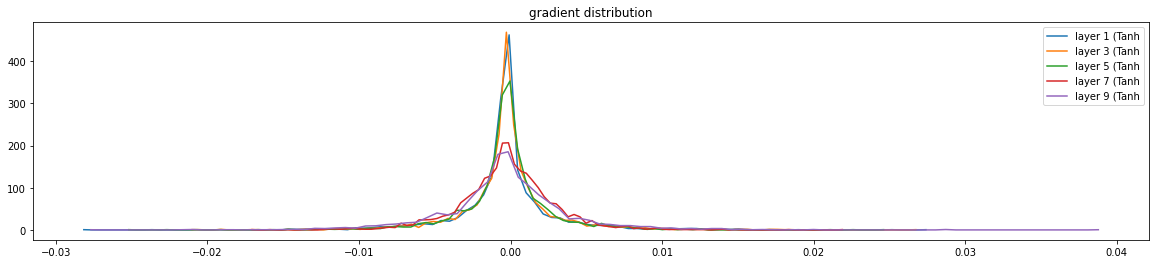

In [112]:
# ----- Histogram of Tanh Layers ----- #
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.output.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

In [113]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = lookup_table[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(integer_to_string[i] for i in out)) # decode and print the generated word

eriah.
myah.
keen.
ndery.
lorethruthadrieg.
adee.
daeline.
mylonna.
keisencanar.
kate.
monte.
cayshabergiaganest.
jairenderrenter.
fouszenedi.
kymbuezeki.
kayshayveude.
hel.
salynn.
khazelloveuren.
credis.
